In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive

#Mount Google Drive
drive.mount('/content/MyDrive/')

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


In [3]:
# Define the path to the excel file (replace with your file path on Google Drive)
file_path = '/content/MyDrive/MyDrive/dfPD.csv'

In [4]:
# Read the .csv file into a DataFrame
df = pd.read_csv(file_path)

In [5]:
# Display the first few rows of the DataFrame
print(df.head())

              Datetime  Total_Pedestrians
0  2018-01-01 00:00:00             1071.0
1  2018-01-01 01:00:00              561.0
2  2018-01-01 02:00:00              373.0
3  2018-01-01 03:00:00              233.0
4  2018-01-01 04:00:00              184.0


In [6]:
# Calculate the percentage of missing values per column
missing_percentage = df.isnull().mean() * 100

# Print the missing percentage per column
print("Percentage of missing values per column:")
print(missing_percentage)

Percentage of missing values per column:
Datetime             0.000000
Total_Pedestrians    0.318464
dtype: float64


In [9]:
# Ensure Datetime is in the correct format and set as index
df = df.reset_index()
df['Datetime'] = pd.to_datetime(df['Datetime'])  #Now you can convert it

df.set_index('Datetime', inplace=True) # Set it back as index

# Filter data for 2018
df1 = df.loc['2018']

# Apply backward fill to the RH column for 2018
df.loc['2018', 'Total_Pedestrians'] = df1['Total_Pedestrians'].fillna(method='bfill')

# Verify the missing values are filled
print("Missing values in Total_Pedestrians after backward fill for 2018:")
print(df.loc['2018', 'Total_Pedestrians'].isnull().sum())

Missing values in Total_Pedestrians after backward fill for 2018:
0


<ipython-input-9-fe5d36e084ec>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.loc['2018', 'Total_Pedestrians'] = df1['Total_Pedestrians'].fillna(method='bfill')


In [10]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Total_Pedestrians  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


                     Total_Pedestrians
Datetime                              
2018-01-01 00:00:00             1071.0
2018-01-01 01:00:00              561.0
2018-01-01 02:00:00              373.0
2018-01-01 03:00:00              233.0
2018-01-01 04:00:00              184.0
...                                ...
2018-12-31 19:00:00            10761.0
2018-12-31 20:00:00            12967.0
2018-12-31 21:00:00            15612.0
2018-12-31 22:00:00            18619.0
2018-12-31 23:00:00            20666.0

[8760 rows x 1 columns]

Missing Values per Column:
Total_Pedestrians    0
dtype: int64

Percentage of Missing Values per Column:
Total_Pedestrians    0.0
dtype: float64

Rows with Missing Values:
Empty DataFrame
Columns: [Total_Pedestrians]
Index: []


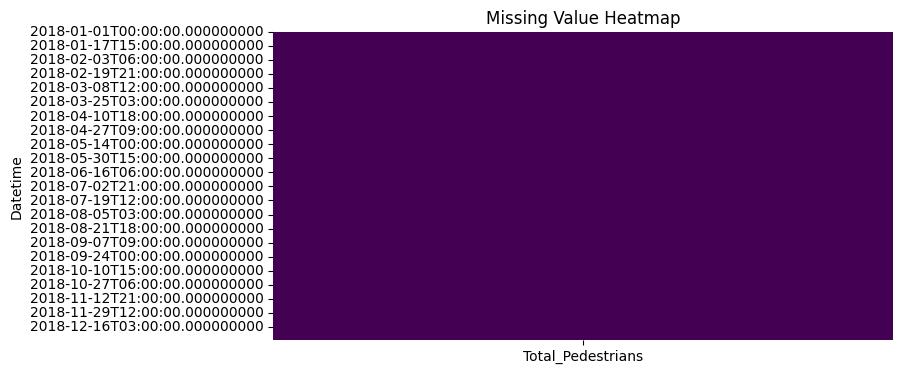


Pattern of Missingness:
0    8760
Name: count, dtype: int64


In [11]:
print(df1)

# Total missing values per column
print("\nMissing Values per Column:")
print(df1.isnull().sum())

# Percentage of missing values per column
print("\nPercentage of Missing Values per Column:")
print(df1.isnull().mean() * 100)

# Rows with missing values
print("\nRows with Missing Values:")
print(df1[df1.isnull().any(axis=1)])

# Visualize missingness
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.heatmap(df1.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Value Heatmap")
plt.show()

# Check patterns of missingness
print("\nPattern of Missingness:")
print(df1.isnull().sum(axis=1).value_counts())

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Feature engineering from 'Datetime'
df1['hour'] = df1.index.hour  # Extract hour from Datetime
df1['day_of_week'] = df1.index.dayofweek  # Extract day of the week
df1['month'] = df1.index.month  # Extract month

# Select features (using 'Datetime' features and Total_Pedestrians )
features = ["hour", "day_of_week", "month"]

# Create lag features for Total_Pedestrians (Using past 24 hours of Total_Pedestrians  data)
for lag in range(1, 25):  # Create lag features for 24 previous hours of Total_Pedestrians
    df1[f"Total_Pedestrians_lag{lag}"] = df1["Total_Pedestrians"].shift(lag)

# Drop rows with missing values due to lag features
df1 = df1.dropna()

# Define X (independent variables) and y (target variable)
X = df1[features + [f"Total_Pedestrians_lag{lag}" for lag in range(1, 25)]]
y = df1["Total_Pedestrians"]

# Standardize features (not target variable)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = rf_model.predict(X_test)


In [13]:
#Evaluate model performance
# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)  # Remove squared parameter
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE manually
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")


MAE: 461.758
RMSE: 898.812
R² Score: 0.980


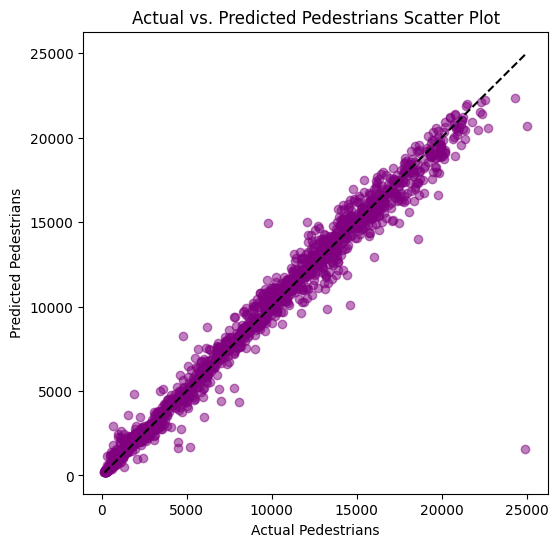

In [15]:
#scater splot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="purple")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="dashed", color="black")  # 45-degree reference line
plt.xlabel("Actual Pedestrians")
plt.ylabel("Predicted Pedestrians")
plt.title("Actual vs. Predicted Pedestrians Scatter Plot")
plt.show()